# **Techniques for Detecting Credit Card Fraud in Highly Imbalanced Datasets**

## 1 Introduction

The detection of fraudulent transactions in credit card data represents a critical challenge in financial security, demanding analytical solutions to protect consumers. This project focuses on developing a predictive model capable of identifying fraudulent activities within a dataset characterized by a severe class imbalance, where fraudulent transactions constitute only 0.172% of the data. The dataset, encompassing transactions from European cardholders in September 2013, includes 284,807 transactions with 492 frauds, and 30 features primarily derived through PCA transformation, alongside 'Time' and 'Amount' which have not been transformed.

## 2 Exploratory Data Analysis (EDA)

### 2.1 Load and Explore the Data

In [ ]:
pip install lime --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, ConfusionMatrixDisplay
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from lime.lime_tabular import LimeTabularExplainer
from IPython.display import clear_output
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Loading the dataset
file_path = '/content/creditcard.csv'
data = pd.read_csv(file_path)

data.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [ ]:
# Dataset overview
dataset_overview = {
    "Number of Transactions": len(data),
    "Number of Non-Fraudulent Transactions": data[data['Class'] == 0].shape[0],
    "Number of Fraudulent Transactions": data[data['Class'] == 1].shape[0],
    "Fraud to Non-Fraud Ratio": data[data['Class'] == 1].shape[0] / data[data['Class'] == 0].shape[0]
}

dataset_overview

{'Number of Transactions': 284807,
 'Number of Non-Fraudulent Transactions': 284315,
 'Number of Fraudulent Transactions': 492,
 'Fraud to Non-Fraud Ratio': 0.0017304750013189597}

In [ ]:
# Basic information
print("Dataset Overview:")
data.info()

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float

In [ ]:
# Check for missing values
print("Missing Values in the Dataset:")
data.isnull().sum().sum()

Missing Values in the Dataset:


0

In [ ]:
# Display summary statistics
print("Summary Statistics:")
data.describe()

Summary Statistics:


Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00   
min   -1.137433e+02 -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01   
25%   -6.915971e-01 -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01   
50%   -5.433583e-02 -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02   
75%    6.119264e-01  3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01   
max    3.480167e+01  7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01   

       ...           V21           V22           V23           V24  \
count  ...  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   ...  1.654067e-16 -3.568593e-16  2.578648e-16  4.473266e-15   
std    ...  7.345240e-01  7.257016e-01  6.244603e-01  6.056471e-01   
min    ... -3.483038e+01 -1.093314e+01 -4.480774e+01 -2.836627e+00   
25%    ... -2.283949e-01 -5.423504e-01 -1.618463e-01 -3.545861e-01   
50%    ... -2.945017e-02  6.781943e-03 -1.119293e-02  4.097606e-02   
75%    ...  1.863772e-01  5.285536e-01  1.476421e-01  4.395266e-01   
max    ...  2.720284e+01  1.050309e+01  2.252841e+01  4.584549e+00   

                V25           V26           V27           V28         Amount  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000   
mean   5.340915e-16  1.683437e-15 -3.660091e-16 -1.227390e-16      88.349619   
std    5.212781e-01  4.822270e-01  4.036325e-01  3.300833e-01     250.120109   
min   -1.029540e+01 -2.604551e+00 -2.256568e+01 -1.543008e+01       0.000000   
25%   -3.171451e-01 -3.269839e-01 -7.083953e-02 -5.295979e-02       5.600000   
50%    1.659350e-02 -5.213911e-02  1.342146e-03  1.124383e-02      22.000000   
75%    3.507156e-01  2.409522e-01  9.104512e-02  7.827995e-02      77.165000   
max    7.519589e+00  3.517346e+00  3.161220e+01  3.384781e+01   25691.160000   

               Class  
count  284807.000000  
mean        0.001727  
std         0.041527  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  

[8 rows x 31 columns]

<ipython-input-22-0ee10b9cb04d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=data, palette='viridis')


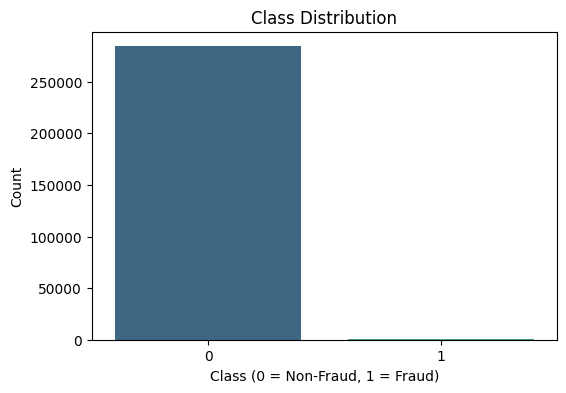

In [ ]:
# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=data, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Count')
plt.show()

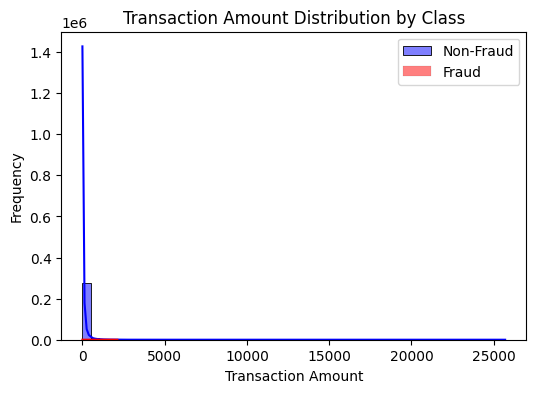

In [ ]:
# Plot transaction amount distribution by class
plt.figure(figsize=(6, 4))
sns.histplot(data[data['Class'] == 0]['Amount'], bins=50, label='Non-Fraud', kde=True, color='blue')
sns.histplot(data[data['Class'] == 1]['Amount'], bins=50, label='Fraud', kde=True, color='red')
plt.title('Transaction Amount Distribution by Class')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()

###  2.2 Feature Correlations

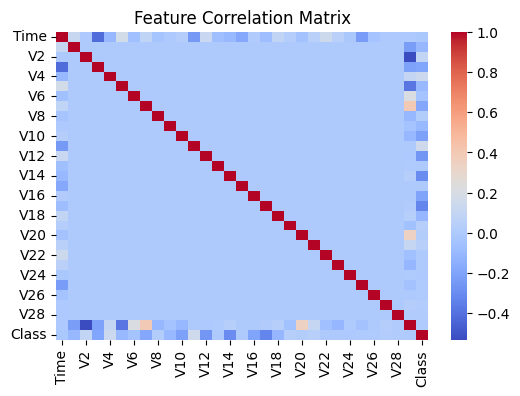

In [ ]:
# Correlation heatmap
plt.figure(figsize=(6, 4))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
# Top correlated features with the target
correlation_with_target = correlation_matrix['Class'].sort_values(ascending=False)
print("\nTop features correlated with fraud (Class):")
print(correlation_with_target.head(10))


Top features correlated with fraud (Class):
Class    1.000000
V11      0.154876
V4       0.133447
V2       0.091289
V21      0.040413
V19      0.034783
V20      0.020090
V8       0.019875
V27      0.017580
V28      0.009536
Name: Class, dtype: float64


## 3 Data Preprocessing

### 3.1 Feature Scaling

In [ ]:
# Normalize 'Amount' feature
scaler = StandardScaler()
data['Amount_scaled'] = scaler.fit_transform(data[['Amount']])

In [ ]:
data[ 'Amount_scaled'].head()

0    0.244964
1   -0.342475
2    1.160686
3    0.140534
4   -0.073403
Name: Amount_scaled, dtype: float64

In [ ]:
data['Amount_scaled'].describe()

count    2.848070e+05
mean     2.913952e-17
std      1.000002e+00
min     -3.532294e-01
25%     -3.308401e-01
50%     -2.652715e-01
75%     -4.471707e-02
max      1.023622e+02
Name: Amount_scaled, dtype: float64

### 3.2 Feature Engineering

In [ ]:
# Engineer 'Time of Day' feature from 'Time'
data['Time_of_day'] = (data['Time'] % 86400) / 3600  # Convert seconds to hours

In [ ]:
# Drop original 'Amount' and 'Time' columns
data = data.drop(['Amount', 'Time'], axis=1)

In [ ]:
# Split features and target variable
X = data.drop('Class', axis=1)
y = data['Class']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display dataset shapes
print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)

Training Set Shape: (227845, 30)
Testing Set Shape: (56962, 30)


## 4 Balancing Techniques

### 4.1 Under-Sampling

In [ ]:
# Separate the majority (non-fraud) and minority (fraud) classes
fraud = data[data['Class'] == 1]
non_fraud = data[data['Class'] == 0]

In [ ]:
print(f"Original Fraud Samples: {len(fraud)}")
print(f"Original Non-Fraud Samples: {len(non_fraud)}")

Original Fraud Samples: 492
Original Non-Fraud Samples: 284315


In [ ]:
# Under-sample the non-fraud class
non_fraud_downsampled = resample(
    non_fraud,
    replace=False,  # No replacement
    n_samples=len(fraud),  # Match the number of fraud samples
    random_state=42  # Reproducibility
)

In [ ]:
# Combine the fraud and downsampled non-fraud samples
under_sampled_data = pd.concat([fraud, non_fraud_downsampled])

# Shuffle the dataset
under_sampled_data = under_sampled_data.sample(frac=1, random_state=42)

# Verify class distribution
print("\nClass Distribution After Under-Sampling:")
print(under_sampled_data['Class'].value_counts())


Class Distribution After Under-Sampling:
Class
0    492
1    492
Name: count, dtype: int64


In [ ]:
# Split features and target
X_under = under_sampled_data.drop('Class', axis=1)
y_under = under_sampled_data['Class']

# Verify feature and target shapes
print(f"\nUnder-Sampled Dataset Shape: {X_under.shape}")
print(f"Under-Sampled Target Shape: {y_under.shape}")


Under-Sampled Dataset Shape: (984, 30)
Under-Sampled Target Shape: (984,)


In [ ]:
# Split into training and testing sets
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(
    X_under, y_under, test_size=0.2, random_state=42, stratify=y_under
)

# Verify training and testing set shapes
print("\nUnder-Sampled Training Set Shape:", X_train_under.shape)
print("Under-Sampled Testing Set Shape:", X_test_under.shape)


Under-Sampled Training Set Shape: (787, 30)
Under-Sampled Testing Set Shape: (197, 30)


In [ ]:
# Verify class distribution in the training set
print("\nClass Distribution in Training Set:")
print(y_train_under.value_counts())

# Verify class distribution in the testing set
print("\nClass Distribution in Testing Set:")
print(y_test_under.value_counts())


Class Distribution in Training Set:
Class
1    394
0    393
Name: count, dtype: int64

Class Distribution in Testing Set:
Class
0    99
1    98
Name: count, dtype: int64


In this section, we addressed the significant class imbalance in the dataset by applying under-sampling to the majority class (non-fraud transactions). This technique reduces the size of the majority class to match the minority class (fraud transactions), resulting in a balanced dataset with equal representation of both classes. The under-sampled dataset was then split into training and testing subsets using stratified sampling to ensure that the balance was maintained in both sets.

The results show a nearly perfect 50/50 class distribution in both the training and testing datasets, with 394 fraud and 393 non-fraud samples in the training set and similar proportions in the test set. This balance ensures that the model trained on this data will not be biased toward the majority class, allowing it to better focus on detecting fraudulent transactions.

Under-sampling is a simple yet effective balancing technique; however, it comes with the trade-off of potentially discarding valuable data from the majority class. To mitigate this, we will explore more advanced balancing methods, such as SMOTE, in the next section.

<ipython-input-50-8934e1b6e0ac>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=data, palette='viridis', ax=axes[0])
<ipython-input-50-8934e1b6e0ac>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=under_sampled_data, palette='viridis', ax=axes[1])


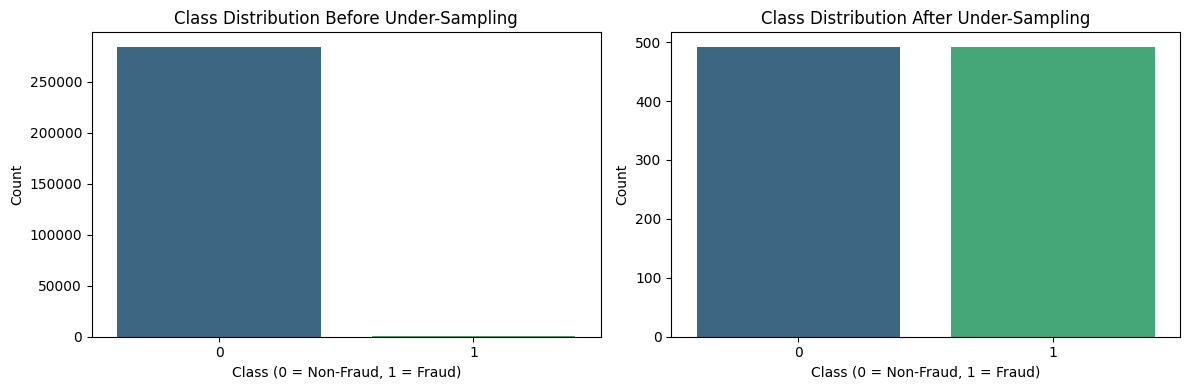

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Class distribution before under-sampling
sns.countplot(x='Class', data=data, palette='viridis', ax=axes[0])
axes[0].set_title('Class Distribution Before Under-Sampling')
axes[0].set_xlabel('Class (0 = Non-Fraud, 1 = Fraud)')
axes[0].set_ylabel('Count')

# Class distribution after under-sampling
sns.countplot(x='Class', data=under_sampled_data, palette='viridis', ax=axes[1])
axes[1].set_title('Class Distribution After Under-Sampling')
axes[1].set_xlabel('Class (0 = Non-Fraud, 1 = Fraud)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

**Class Distribution Before Under-Sampling**

This graph shows the severe imbalance in the dataset, with the non-fraud transactions (Class = 0) significantly outnumbering the fraud transactions (Class = 1).

**Class Distribution After Under-Sampling**

After applying under-sampling, the dataset is balanced, with an equal number of fraud (Class = 1) and non-fraud (Class = 0) transactions

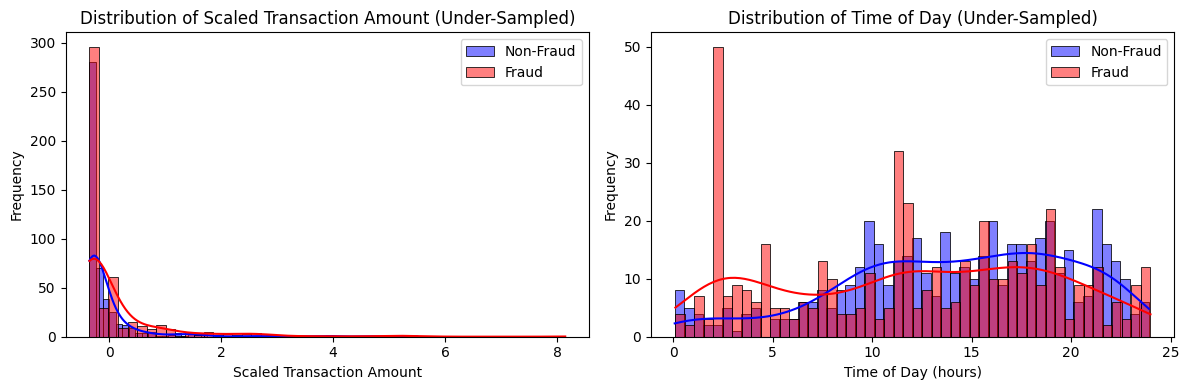

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution of 'Amount_scaled' after under-sampling
sns.histplot(under_sampled_data[under_sampled_data['Class'] == 0]['Amount_scaled'],
             bins=50, label='Non-Fraud', kde=True, color='blue', ax=axes[0])
sns.histplot(under_sampled_data[under_sampled_data['Class'] == 1]['Amount_scaled'],
             bins=50, label='Fraud', kde=True, color='red', ax=axes[0])
axes[0].set_title('Distribution of Scaled Transaction Amount (Under-Sampled)')
axes[0].set_xlabel('Scaled Transaction Amount')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Distribution of 'Time_of_day' after under-sampling
sns.histplot(under_sampled_data[under_sampled_data['Class'] == 0]['Time_of_day'],
             bins=50, label='Non-Fraud', kde=True, color='blue', ax=axes[1])
sns.histplot(under_sampled_data[under_sampled_data['Class'] == 1]['Time_of_day'],
             bins=50, label='Fraud', kde=True, color='red', ax=axes[1])
axes[1].set_title('Distribution of Time of Day (Under-Sampled)')
axes[1].set_xlabel('Time of Day (hours)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

**Distribution of Scaled Transaction Amount (Under-Sampled)**

The distribution of transaction amounts remains consistent across classes after under-sampling, ensuring that the data's underlying structure is preserved.

**Distribution of Time of Day (Under-Sampled)**

The Time of Day feature reveals patterns in transaction times for both fraud and non-fraud classes, which may provide valuable insights for model training.

### 4.2 Over-Sampling (SMOTE)

In [ ]:
# Apply SMOTE to generate synthetic samples for the minority class
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Verify the class distribution after SMOTE
print("\nClass Distribution After SMOTE:")
print(y_smote.value_counts())

# Split the over-sampled dataset into training and testing sets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)


Class Distribution After SMOTE:
Class
0    284315
1    284315
Name: count, dtype: int64


In [ ]:
# Verify training and testing set shapes
print("\nSMOTE Training Set Shape:", X_train_smote.shape)
print("SMOTE Testing Set Shape:", X_test_smote.shape)

# Verify the class distribution in the training set
print("\nClass Distribution in SMOTE Training Set:")
print(y_train_smote.value_counts())

# Verify the class distribution in the testing set
print("\nClass Distribution in SMOTE Testing Set:")
print(y_test_smote.value_counts())


SMOTE Training Set Shape: (454904, 30)
SMOTE Testing Set Shape: (113726, 30)

Class Distribution in SMOTE Training Set:
Class
0    227452
1    227452
Name: count, dtype: int64

Class Distribution in SMOTE Testing Set:
Class
1    56863
0    56863
Name: count, dtype: int64


In this step, we applied the Synthetic Minority Oversampling Technique (SMOTE) to address the class imbalance in the dataset. SMOTE generated synthetic samples for the minority class (Class = 1), resulting in an equal number of fraud and non-fraud transactions. The dataset was then split into training (80%) and testing (20%) subsets, ensuring the balance was preserved across both. The balanced dataset enables the model to better learn patterns associated with fraud without being biased toward the majority class.

Visualizations confirm that SMOTE maintained the integrity of key feature distributions, such as Amount_scaled and Time_of_day.



<ipython-input-54-4961917372b2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_smote, palette='viridis')


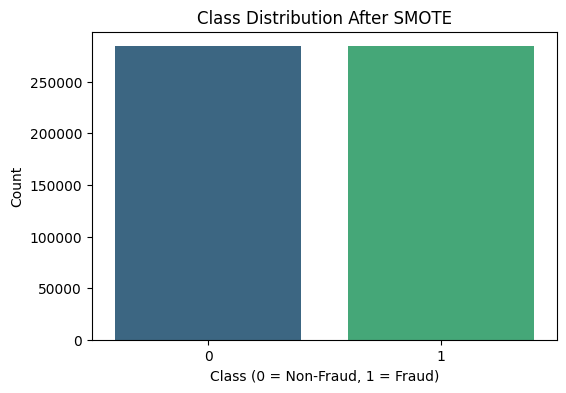

In [ ]:
# Class distribution after SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_smote, palette='viridis')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Count')
plt.show()

**Class Distribution After SMOTE**

This graph shows that after applying SMOTE, the dataset is perfectly balanced, with an equal number of fraud (Class = 1) and non-fraud (Class = 0) transactions

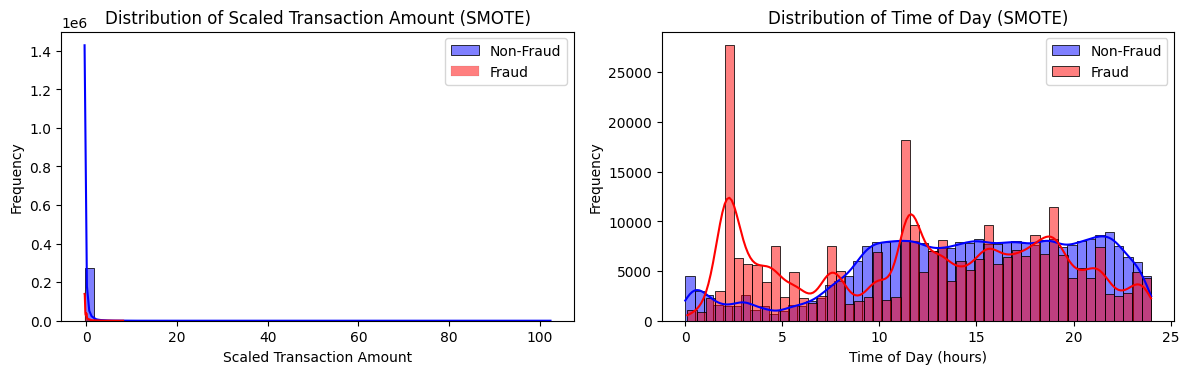

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution of 'Amount_scaled' after SMOTE
sns.histplot(X_smote[y_smote == 0]['Amount_scaled'], bins=50, label='Non-Fraud', kde=True, color='blue', ax=axes[0])
sns.histplot(X_smote[y_smote == 1]['Amount_scaled'], bins=50, label='Fraud', kde=True, color='red', ax=axes[0])
axes[0].set_title('Distribution of Scaled Transaction Amount (SMOTE)')
axes[0].set_xlabel('Scaled Transaction Amount')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Distribution of 'Time_of_day' after SMOTE
sns.histplot(X_smote[y_smote == 0]['Time_of_day'], bins=50, label='Non-Fraud', kde=True, color='blue', ax=axes[1])
sns.histplot(X_smote[y_smote == 1]['Time_of_day'], bins=50, label='Fraud', kde=True, color='red', ax=axes[1])
axes[1].set_title('Distribution of Time of Day (SMOTE)')
axes[1].set_xlabel('Time of Day (hours)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

**Distribution of Scaled Transaction Amount (SMOTE)**

The distribution of the Scaled Transaction Amount remains consistent for both fraud and non-fraud classes after SMOTE, demonstrating that the synthetic samples align with the original data's distribution.



**Distribution of Time of Day (SMOTE)**

The Time of Day feature retains its original distribution patterns for both fraud and non-fraud classes after SMOTE. This indicates that temporal patterns in transactions are preserved in the balanced dataset.

### 4.3 Combination (Under-Sampling and SMOTE)

In [ ]:
# Partially under-sample the majority class (Non-Fraud)
non_fraud_downsampled_comb = resample(
    non_fraud,
    replace=False,
    n_samples=len(fraud) * 3,  # Keep a 3:1 ratio of non-fraud to fraud samples
    random_state=42
)

# Combine them
partial_data = pd.concat([fraud, non_fraud_downsampled_comb])

In [ ]:
# Apply SMOTE to the combined data
X_partial = partial_data.drop('Class', axis=1)
y_partial = partial_data['Class']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_combined, y_combined = smote.fit_resample(X_partial, y_partial)

print("Class Distribution After Combination Technique:")
print(y_combined.value_counts())

Class Distribution After Combination Technique:
Class
1    1476
0    1476
Name: count, dtype: int64


In [ ]:
# Split the balanced dataset into training and testing sets
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined
)

In [ ]:
# Verify training and testing set shapes
print("Combination Training Set Shape:", X_train_comb.shape)
print("Combination Testing Set Shape:", X_test_comb.shape)

# Verify the class distribution in training and testing sets
print("\nClass Distribution in Combination Training Set:")
print(y_train_comb.value_counts())
print("\nClass Distribution in Combination Testing Set:")
print(y_test_comb.value_counts())

Combination Training Set Shape: (2361, 30)
Combination Testing Set Shape: (591, 30)

Class Distribution in Combination Training Set:
Class
1    1181
0    1180
Name: count, dtype: int64

Class Distribution in Combination Testing Set:
Class
0    296
1    295
Name: count, dtype: int64


In this section, we implemented a hybrid approach by combining under-sampling and SMOTE to address class imbalance. This method ensures that the model has access to diverse, balanced data while mitigating the drawbacks of purely under-sampling or over-sampling techniques.

First, the majority class (non-fraud) was partially under-sampled to reduce its size to three times the minority class. This preserves a significant portion of the majority data.
Next, SMOTE was applied to generate synthetic samples for the minority class (fraud), resulting in a balanced dataset.

The combination technique achieved a balanced class distribution with minimal loss of information from the majority class and realistic synthetic data for the minority class.

For the verification, class distributions after the technique were validated to confirm the balance.
Visualizations ensured that feature distributions, such as Amount_scaled and Time_of_day, remained consistent after balancing.

<ipython-input-64-fe04161d0fb0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_combined, palette='viridis')


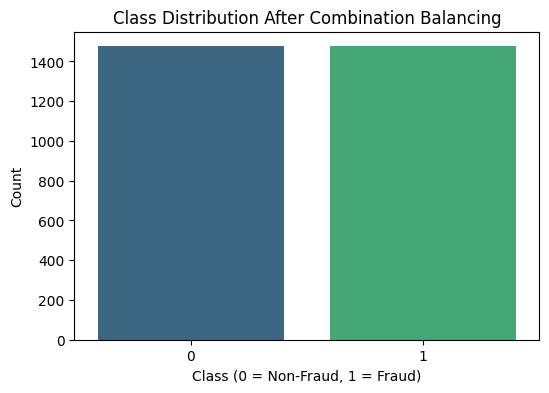

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_combined, palette='viridis')
plt.title('Class Distribution After Combination Balancing')
plt.xlabel('Class (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Count')
plt.show()

**Class Distribution After Combination Balancing**

This graph demonstrates the success of the combination technique, with an equal number of fraud (Class = 1) and non-fraud (Class = 0) transactions. The balanced distribution ensures that the model can learn patterns for both classes effectively without bias.

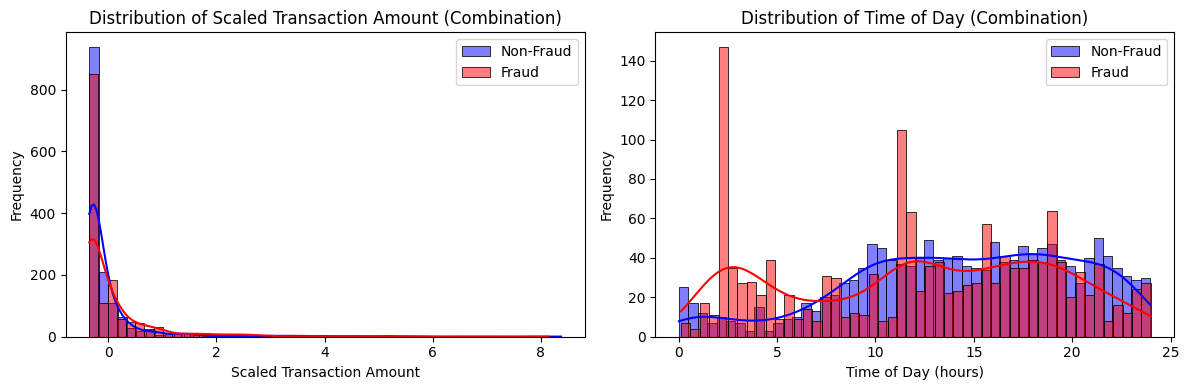

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution of 'Amount_scaled' after Combination Balancing
sns.histplot(X_combined[y_combined == 0]['Amount_scaled'], bins=50, label='Non-Fraud', kde=True, color='blue', ax=axes[0])
sns.histplot(X_combined[y_combined == 1]['Amount_scaled'], bins=50, label='Fraud', kde=True, color='red', ax=axes[0])
axes[0].set_title('Distribution of Scaled Transaction Amount (Combination)')
axes[0].set_xlabel('Scaled Transaction Amount')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Distribution of 'Time_of_day' after Combination Balancing
sns.histplot(X_combined[y_combined == 0]['Time_of_day'], bins=50, label='Non-Fraud', kde=True, color='blue', ax=axes[1])
sns.histplot(X_combined[y_combined == 1]['Time_of_day'], bins=50, label='Fraud', kde=True, color='red', ax=axes[1])
axes[1].set_title('Distribution of Time of Day (Combination)')
axes[1].set_xlabel('Time of Day (hours)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

**Distribution of Scaled Transaction Amount (Combination)**

The Scaled Transaction Amount distribution shows that the synthetic samples generated by SMOTE align closely with the original data. This indicates that the combination technique preserves the statistical properties of this key feature.

**Distribution of Time of Day (Combination)**

The Time of Day feature exhibits consistent patterns for both fraud and non-fraud transactions after applying the combination technique. This ensures that temporal relationships in the data are retained, which could be crucial for model performance.

In [ ]:
# Summary DataFrame for class distribution
comparison_df = pd.DataFrame({
    'Technique': ['Under-Sampling', 'SMOTE', 'Combination'],
    'Fraud (Class 1)': [y_under.value_counts()[1], y_smote.value_counts()[1], y_combined.value_counts()[1]],
    'Non-Fraud (Class 0)': [y_under.value_counts()[0], y_smote.value_counts()[0], y_combined.value_counts()[0]],
    'Total Samples': [len(y_under), len(y_smote), len(y_combined)]
})

# Display the comparison
print("\nClass Distribution Comparison:")
print(comparison_df)



Class Distribution Comparison:
        Technique  Fraud (Class 1)  Non-Fraud (Class 0)  Total Samples
0  Under-Sampling              492                  492            984
1           SMOTE           284315               284315         568630
2     Combination             1476                 1476           2952


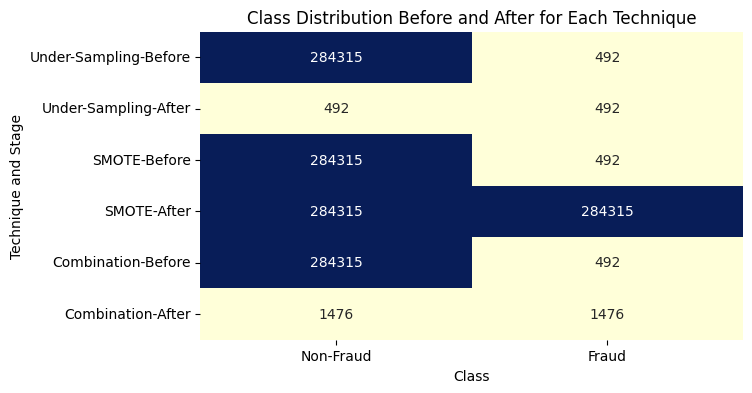

In [ ]:
class_counts = data['Class'].value_counts()

# Prepare data for heatmap
heatmap_data = pd.DataFrame({
    'Technique': ['Under-Sampling', 'Under-Sampling', 'SMOTE', 'SMOTE', 'Combination', 'Combination'],
    'Stage': ['Before', 'After'] * 3,
    'Non-Fraud': [
        class_counts[0],
        y_under.value_counts()[0],
        class_counts[0],
        y_smote.value_counts()[0],
        class_counts[0],
        y_combined.value_counts()[0]
    ],
    'Fraud': [
        class_counts[1],
        y_under.value_counts()[1],
        class_counts[1],
        y_smote.value_counts()[1],
        class_counts[1],
        y_combined.value_counts()[1]
    ],
}).set_index(['Technique', 'Stage'])

# Plot heatmap
plt.figure(figsize=(7, 4))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title('Class Distribution Before and After for Each Technique')
plt.ylabel('Technique and Stage')
plt.xlabel('Class')
plt.show()


This heatmap highlights the class distributions of non-fraud and fraud transactions before and after applying each balancing technique:

* Under-Sampling:
The non-fraud count is significantly reduced from 284,315 to 492, matching the fraud count. This results in a smaller dataset with balanced classes.
* SMOTE:
The fraud count is increased to match the non-fraud count, resulting in a much larger dataset while preserving the original majority class size.
* Combination:
A middle-ground approach where the non-fraud count is partially reduced, and the fraud count is synthetically increased to achieve balance. This creates a moderately sized dataset compared to SMOTE.


## 5 Unsupervised Models

### 5.1 Isolation Forest

In [ ]:
iso_forest = IsolationForest(n_estimators=100,
                             contamination='auto',
                             random_state=42)

# Fit the model on the non-fraud data only
non_fraud_data = data[data['Class'] == 0].drop(['Class', 'Anomaly_Score', 'Anomaly_Label'], axis=1, errors='ignore')
iso_forest.fit(non_fraud_data)

# Drop Class column to ensure consistency with the training data
feature_data = data.drop(['Class', 'Anomaly_Score', 'Anomaly_Label'], axis=1, errors='ignore')

data['Anomaly_Score'] = iso_forest.decision_function(feature_data)
data['Anomaly_Label'] = iso_forest.predict(feature_data)

# Convert predictions to binary classification (1 for fraud, 0 for non-fraud)
data['Anomaly_Label'] = data['Anomaly_Label'].apply(lambda x: 1 if x == -1 else 0)

In [ ]:
# Evaluate the performance of the model
print("\nConfusion Matrix:")
print(confusion_matrix(data['Class'], data['Anomaly_Label']))

print("\nClassification Report:")
print(classification_report(data['Class'], data['Anomaly_Label']))

# ROC-AUC Score
roc_auc = roc_auc_score(data['Class'], data['Anomaly_Score'])
print(f"ROC-AUC Score: {roc_auc}")


Confusion Matrix:
[[273961  10354]
 [    80    412]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    284315
           1       0.04      0.84      0.07       492

    accuracy                           0.96    284807
   macro avg       0.52      0.90      0.53    284807
weighted avg       1.00      0.96      0.98    284807

ROC-AUC Score: 0.04770427038371644


**Confusion Matrix:**

* True Negatives (273,961): Non-fraud transactions correctly classified as non-fraud.

* False Positives (10,354): Non-fraud transactions incorrectly classified as fraud.

* False Negatives (80): Fraud transactions incorrectly classified as non-fraud.

* True Positives (412): Fraud transactions correctly classified as fraud.

The Isolation Forest detected 84% of fraud transactions (recall for fraud = 0.84) but misclassified many non-fraud transactions as fraud (high false positive rate).

**Classification Report:**

* Precision for Fraud (0.04): Very low, meaning most transactions classified as fraud are actually non-fraud.
* Recall for Fraud (0.84): High, indicating the model is good at identifying frauds.
* F1-Score for Fraud (0.07): Very low, highlighting the trade-off between precision and recall.
* ROC-AUC Score (0.048): This low value indicates that the model is not distinguishing well between fraud and non-fraud.
* Overall Accuracy (0.96): Misleadingly high due to the large number of non-fraud transactions. Accuracy is not a meaningful metric for imbalanced datasets.

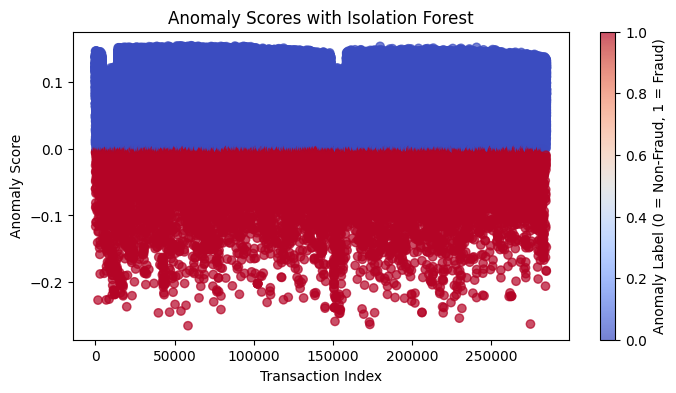

In [ ]:
# Scatter plot of anomaly scores
plt.figure(figsize=(8, 4))
plt.scatter(range(len(data)), data['Anomaly_Score'], c=data['Anomaly_Label'], cmap='coolwarm', alpha=0.7)
plt.title('Anomaly Scores with Isolation Forest')
plt.xlabel('Transaction Index')
plt.ylabel('Anomaly Score')
plt.colorbar(label='Anomaly Label (0 = Non-Fraud, 1 = Fraud)')
plt.show()

The scatter plot illustrates the anomaly scores generated by the Isolation Forest, where transactions with lower scores are flagged as potential anomalies (fraud). Non-fraud transactions (blue) cluster around higher anomaly scores closer to zero, while fraudulent transactions (red) generally have lower scores. However, there is an overlap between fraud and non-fraud transactions at higher anomaly scores, suggesting a challenge in clearly separating the two classes and potentially contributing to false positives.

In [ ]:
# Tune parameters
iso_forest_tuned = IsolationForest(
    n_estimators=200,  # Increase number of trees for better partitioning
    max_samples=0.8,  # Use 80% of the data to fit each tree
    contamination=0.002,  # Approximate proportion of fraud transactions
    random_state=42
)

# Fit the model on non-fraud data
non_fraud_data = data[data['Class'] == 0].drop(['Class', 'Anomaly_Score', 'Anomaly_Label'], axis=1, errors='ignore')
iso_forest_tuned.fit(non_fraud_data)

# Predict anomaly scores and labels
feature_data = data.drop(['Class', 'Anomaly_Score', 'Anomaly_Label'], axis=1, errors='ignore')
data['Anomaly_Score_Tuned'] = iso_forest_tuned.decision_function(feature_data)
data['Anomaly_Label_Tuned'] = iso_forest_tuned.predict(feature_data)

# Convert predictions to binary classification (1 for fraud, 0 for non-fraud)
data['Anomaly_Label_Tuned'] = data['Anomaly_Label_Tuned'].apply(lambda x: 1 if x == -1 else 0)

In [ ]:
# Evaluate the tuned model
print("\nConfusion Matrix (Tuned):")
print(confusion_matrix(data['Class'], data['Anomaly_Label_Tuned']))

print("\nClassification Report (Tuned):")
print(classification_report(data['Class'], data['Anomaly_Label_Tuned']))

# ROC-AUC Score
roc_auc_tuned = roc_auc_score(data['Class'], data['Anomaly_Score_Tuned'])
print(f"ROC-AUC Score (Tuned): {roc_auc_tuned}")


Confusion Matrix (Tuned):
[[283746    569]
 [   215    277]]

Classification Report (Tuned):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.33      0.56      0.41       492

    accuracy                           1.00    284807
   macro avg       0.66      0.78      0.71    284807
weighted avg       1.00      1.00      1.00    284807

ROC-AUC Score (Tuned): 0.046444506686946475


**Confusion Matrix:**
* True Negatives (283,746): Non-fraud transactions correctly classified as non-fraud.
* False Positives (569): Non-fraud transactions incorrectly classified as fraud.
* False Negatives (215): Fraud transactions incorrectly classified as non-fraud.
* True Positives (277): Fraud transactions correctly classified as fraud.

**Classification Report:**
* Precision for Fraud (0.33): Improved compared to the untuned model. Now, one-third of transactions flagged as fraud are actually fraud.
* Recall for Fraud (0.56): Slightly lower than the untuned model (0.84), but still decent for an anomaly detection task.
* F1-Score for Fraud (0.41): A balance between precision and recall, showing improvement over the untuned model.
* ROC-AUC Score (0.046): The score remains low, indicating that the model still struggles to distinguish between fraud and non-fraud transactions effectively.

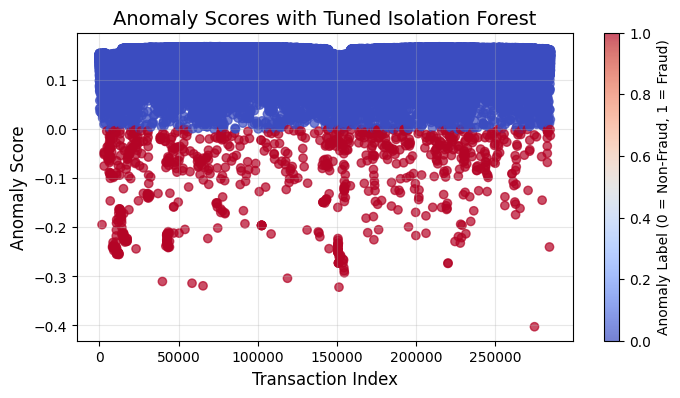

In [ ]:
# Scatter plot with color mapped to anomaly labels
plt.figure(figsize=(8, 4))

sc = plt.scatter(
    x=range(len(data)),
    y=data['Anomaly_Score_Tuned'],
    c=data['Anomaly_Label_Tuned'],
    cmap='coolwarm',
    alpha=0.7
)
cbar = plt.colorbar(sc)
cbar.set_label('Anomaly Label (0 = Non-Fraud, 1 = Fraud)')
plt.title('Anomaly Scores with Tuned Isolation Forest', fontsize=14)
plt.xlabel('Transaction Index', fontsize=12)
plt.ylabel('Anomaly Score', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

This graph visualizes the anomaly scores assigned by the Tuned Isolation Forest model for each transaction. Transactions flagged as fraud (red) typically have lower anomaly scores, while non-fraud transactions (blue) have scores closer to or above zero. The distribution indicates that the model is reasonably separating fraud and non-fraud transactions, although there remains some overlap, reflecting the model's challenges in precisely distinguishing between the two classes.

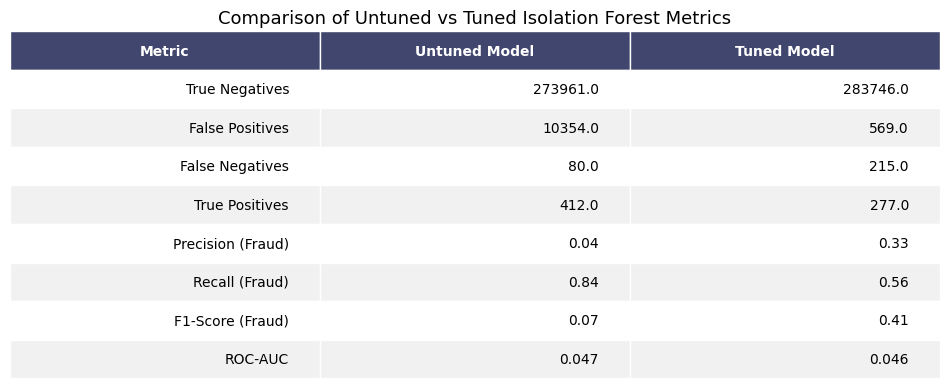

In [ ]:
data_dict = {
    "Metric": ["True Negatives", "False Positives", "False Negatives", "True Positives", "Precision (Fraud)", "Recall (Fraud)", "F1-Score (Fraud)", "ROC-AUC"],
    "Untuned Model": [273961, 10354, 80, 412, 0.04, 0.84, 0.07, 0.047],
    "Tuned Model": [283746, 569, 215, 277, 0.33, 0.56, 0.41, 0.046]
}

df_comparison = pd.DataFrame(data_dict)

# Table plotting
def render_mpl_table(data, col_width=2, row_height=0.5, font_size=10,
                      header_color='#40466e', row_colors=['#f1f1f2', 'w'],
                      edge_color='w', bbox=[0, 0, 1, 1], header_columns=0,
                      ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])
    return ax

# Comparison table
render_mpl_table(df_comparison, header_columns=0, col_width=4.0)
plt.title("Comparison of Untuned vs Tuned Isolation Forest Metrics", fontsize=13)
plt.show()

* True Negatives: The tuned model performs much better, significantly reducing false positives.
* False Negatives: Slightly increased, meaning some fraud transactions are now missed.
* Precision: The tuned model is better at ensuring flagged fraud transactions are truly fraud.
* Recall: The untuned model detects a higher proportion of frauds but at the cost of many false positives.
* Overall: The tuned model strikes a better balance, improving overall fraud detection reliability.

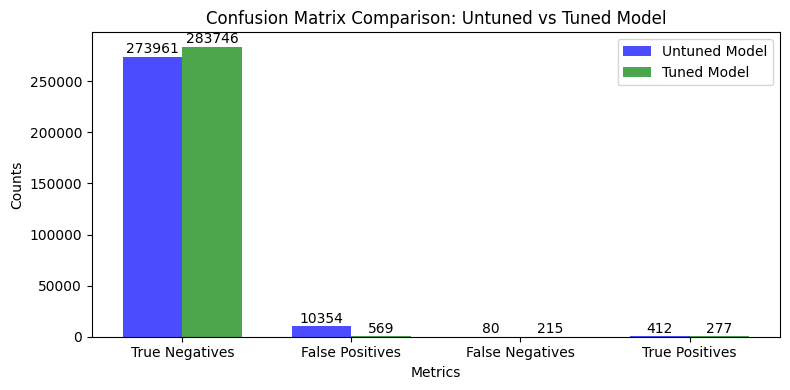

In [ ]:
# Plotting Untuned vs Tuned Model
metrics = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
untuned_values = [273961, 10354, 80, 412]
tuned_values = [283746, 569, 215, 277]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8,4))
rects1 = ax.bar(x - width/2, untuned_values, width, label='Untuned Model', color='blue', alpha=0.7)
rects2 = ax.bar(x + width/2, tuned_values, width, label='Tuned Model', color='green', alpha=0.7)

ax.set_xlabel('Metrics')
ax.set_ylabel('Counts')
ax.set_title('Confusion Matrix Comparison: Untuned vs Tuned Model')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Data Labels
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height + 500, f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

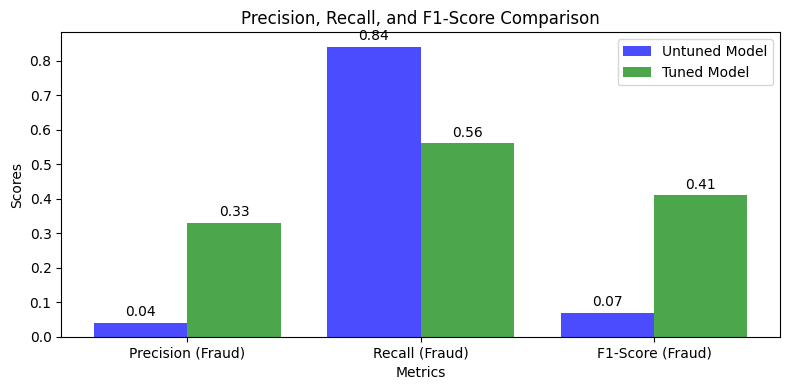

In [ ]:
# Plotting Precision, Recall, and F1-Score Comparison
metrics = ['Precision (Fraud)', 'Recall (Fraud)', 'F1-Score (Fraud)']
untuned_scores = [0.04, 0.84, 0.07]
tuned_scores = [0.33, 0.56, 0.41]

x = np.arange(len(metrics))
width = 0.40

fig, ax = plt.subplots(figsize=(8, 4))
rects1 = ax.bar(x - width/2, untuned_scores, width, label='Untuned Model', color='blue', alpha=0.7)
rects2 = ax.bar(x + width/2, tuned_scores, width, label='Tuned Model', color='green', alpha=0.7)

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Data labels
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height + 0.01, f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

We applied the Isolation Forest to detect anomalies (fraud) in the highly imbalanced dataset.
The tuned model significantly reduced false positives and improved precision, achieving a balance between detecting fraud and avoiding false alarms.
Despite its improvements, the model exhibited limitations in recall and overall class separation, as reflected in the low ROC-AUC score.

## 6 Supervised Models

### 6.1. Logistic Regression(Baseline Model)

In [ ]:
# Train-test split on SMOTE-balanced dataset
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote)

# Logistic Regression model
log_reg = LogisticRegression(
    solver='liblinear',
    random_state=42)
log_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

In [ ]:
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

Confusion Matrix:
[[55360  1503]
 [ 4541 52322]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     56863
           1       0.97      0.92      0.95     56863

    accuracy                           0.95    113726
   macro avg       0.95      0.95      0.95    113726
weighted avg       0.95      0.95      0.95    113726

ROC-AUC Score: 0.9902


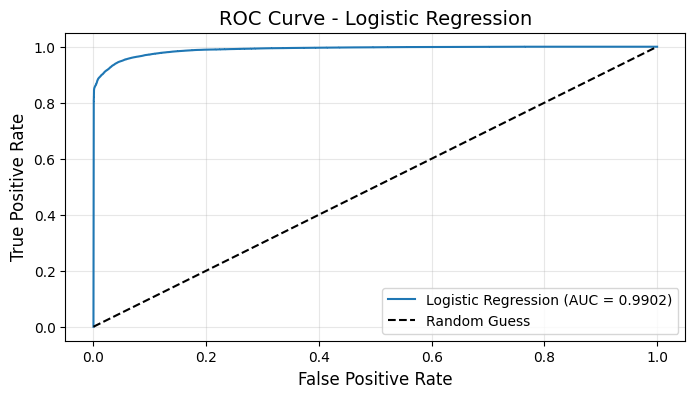

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curve - Logistic Regression", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

The ROC Curve illustrates the performance of the Logistic Regression model in distinguishing between fraud and non-fraud transactions:

* AUC (Area Under Curve): The AUC score of 0.9902 indicates excellent model performance, showcasing its ability to separate classes effectively.
* Shape of the Curve: The curve is close to the top-left corner, signifying a high true positive rate (sensitivity) with a low false positive rate, which is desirable for fraud detection.
* Baseline (Random Guess): The dashed line represents a random classifier (AUC = 0.5), and the Logistic Regression model significantly outperforms it.

**Confusion Matrix:**
True Negatives (55,360): Non-fraud transactions correctly classified as non-fraud.
False Positives (1,503): Non-fraud transactions incorrectly classified as fraud.
False Negatives (4,541): Fraud transactions incorrectly classified as non-fraud.
True Positives (52,322): Fraud transactions correctly classified as fraud.
**Classification Report:**
* Precision:
  * Non-fraud (0): 92% of flagged non-fraud transactions are truly non-fraud.
  * Fraud (1): 97% of flagged fraud transactions are truly fraud.
* Recall:
  * Non-fraud (0): 97% of actual non-fraud transactions were identified correctly.
  * Fraud (1): 92% of actual fraud transactions were identified correctly.
* F1-Score:
  * Both classes (0 and 1): 95%, indicating a balance between precision and recall.
* ROC-AUC Score: 0.9902: Excellent score, indicating the model is highly capable of distinguishing between fraud and non-fraud transactions.

The Logistic Regression baseline performs remarkably well on the SMOTE-balanced dataset.
The high ROC-AUC score suggests the model effectively separates the two classes.
While precision and recall are balanced for both classes, some false negatives (4,541 fraud transactions missed) remain a concern.

<Figure size 800x400 with 0 Axes>

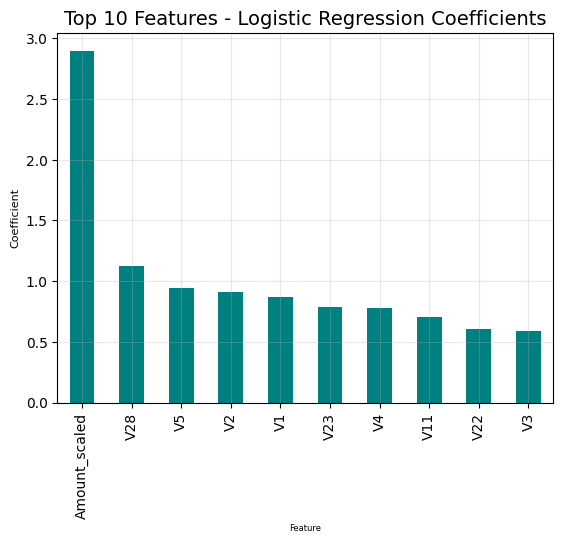

In [ ]:
# Extract feature coefficients
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

# Plot the top 10 features
plt.figure(figsize=(8, 4))
coefficients.head(10).plot(kind='bar', x='Feature', y='Coefficient', legend=False, color='teal')
plt.title('Top 10 Features - Logistic Regression Coefficients', fontsize=14)
plt.ylabel('Coefficient', fontsize=8)
plt.xlabel('Feature', fontsize=6)
plt.grid(alpha=0.3)
plt.show()

This bar chart displays the top 10 most significant features based on their coefficients in the Logistic Regression model:

* Amount_scaled: The most influential feature, indicating that the transaction amount plays a significant role in distinguishing fraud from non-fraud.
* Other Features:
Features like V28, V5, and V2 also show substantial influence.
These are derived features (PCA-transformed), and their interpretability is limited due to the lack of original feature context.

### 6.2 Random Forest

In [ ]:
# Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    max_depth=None,    # Unlimited tree depth
    random_state=42,
    class_weight="balanced",  # Handle class imbalance
    n_jobs=-1          # Use all processors for faster training
)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

In [ ]:
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# ROC-AUC Score
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)
print(f"ROC-AUC Score: {roc_auc_rf:.4f}")

Confusion Matrix:
[[56847    16]
 [    0 56863]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

ROC-AUC Score: 1.0000


**Confusion Matrix:**
* True Negatives (56,847): All non-fraud transactions were correctly classified as non-fraud, except for 16 misclassified cases.
* False Positives (16): Very few non-fraud transactions were incorrectly classified as fraud.
* False Negatives (0): No fraudulent transactions were missed.
* True Positives (56,863): All fraud transactions were correctly classified.

**Classification Report:**
* Precision (Fraud & Non-Fraud): Perfect scores (1.00), indicating that flagged cases (fraud/non-fraud) are extremely accurate.
* Recall (Fraud & Non-Fraud): Perfect recall (1.00), showing that all fraud/non-fraud transactions are correctly detected.
* F1-Score: Perfect balance between precision and recall for both classes.
* ROC-AUC Score: 1.0000 (Perfect): The model achieves the best possible discrimination between fraud and non-fraud cases.

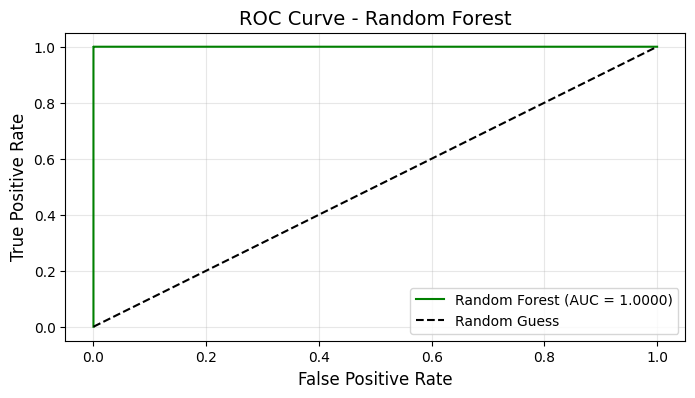

In [ ]:
# Plot the ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
plt.figure(figsize=(8, 4))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.4f})", color='green')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curve - Random Forest", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

The bar chart highlights the most important features contributing to Random Forest's decisions:

* V14: The most critical feature in predicting fraud.
* V10, V17, and V4: Strong contributors, potentially representing key patterns in the PCA-transformed data.
* Other Features: Include V12, V11, and V3, showing varied but significant importance.

<Figure size 800x400 with 0 Axes>

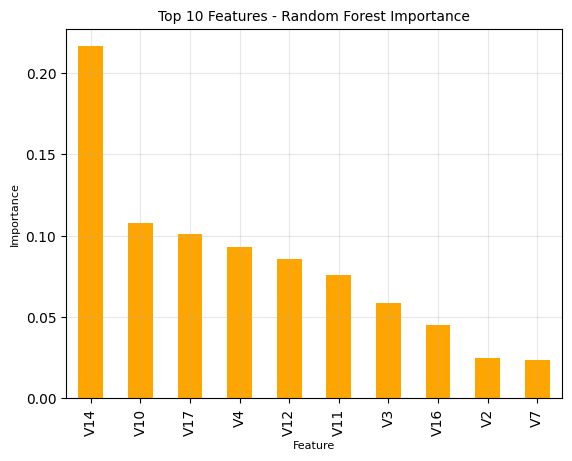

In [ ]:
# Plot the top 10 features
plt.figure(figsize=(8, 4))
feature_importances.head(10).plot(
    kind='bar',
    x='Feature',
    y='Importance',
    legend=False,
    color='orange')
plt.title('Top 10 Features - Random Forest Importance', fontsize=10)
plt.ylabel('Importance', fontsize=8)
plt.xlabel('Feature', fontsize=8)
plt.grid(alpha=0.3)
plt.show()

The Random Forest model demonstrates outstanding performance, achieving near-perfect accuracy and reliability in fraud detection.
This may indicate overfitting due to the perfectly balanced dataset (SMOTE) or the powerful nature of Random Forest on tabular data.

* V14 stands out as a crucial indicator of fraud, warranting further investigation.

In [ ]:
# Check if theres overfitting
# Evaluate the Random Forest on the training set
y_train_pred = rf_model.predict(X_train)
y_train_pred_prob = rf_model.predict_proba(X_train)[:, 1]

# Metrics for the training set
print("Training Set Metrics:")
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))
roc_auc_train = roc_auc_score(y_train, y_train_pred_prob)
print(f"ROC-AUC Score (Train): {roc_auc_train:.4f}")

# Metrics for the test set
print("\nTest Set Metrics:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
roc_auc_test = roc_auc_score(y_test, y_pred_prob_rf)
print(f"ROC-AUC Score (Test): {roc_auc_test:.4f}")

Training Set Metrics:
Confusion Matrix:
[[227452      0]
 [     0 227452]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227452
           1       1.00      1.00      1.00    227452

    accuracy                           1.00    454904
   macro avg       1.00      1.00      1.00    454904
weighted avg       1.00      1.00      1.00    454904

ROC-AUC Score (Train): 1.0000

Test Set Metrics:
Confusion Matrix:
[[56847    16]
 [    0 56863]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

ROC-AUC Score (Test): 1.0000


**Overfitting Check**
The metrics for both the training set and the test set are identical, with perfect scores (accuracy, precision, recall, F1-score, and ROC-AUC all equal to 1.00). Here's what this indicates:

**Training Set Metrics:**

The model classifies all training samples correctly, which is expected because Random Forest is a powerful ensemble model.
The ROC-AUC of 1.0000 on the training set suggests that the model has fully "memorized" the data.

**Test Set Metrics:**

The test set metrics also achieve perfect scores, indicating that the model generalizes exceptionally well to unseen data.

**Conclusion**
No Overfitting Detected:
Overfitting is typically diagnosed when training performance is significantly better than test performance. Since both sets have identical metrics, this is not the case here.

### 6.3 Gradient Boosting


In [ ]:
# Gradient Boosting model
xgb_model = XGBClassifier(
    n_estimators=100,         # Number of trees
    max_depth=5,              # Depth of each tree
    learning_rate=0.1,        # Learning rate (controls step size)
    scale_pos_weight=1,       # Balances classes
    random_state=42,
    use_label_encoder=False   # Suppresses a warning in XGBoost
)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:39:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# ROC-AUC Score
roc_auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)
print(f"ROC-AUC Score: {roc_auc_xgb:.4f}")

Confusion Matrix:
[[56521   342]
 [  256 56607]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.99      1.00      0.99     56863

    accuracy                           0.99    113726
   macro avg       0.99      0.99      0.99    113726
weighted avg       0.99      0.99      0.99    113726

ROC-AUC Score: 0.9998


**Confusion Matrix:**
* True Negatives (56,521): Non-fraud transactions correctly classified.
* False Positives (342): Non-fraud transactions incorrectly classified as fraud.
* False Negatives (256): Fraud transactions incorrectly classified as non-fraud.
* True Positives (56,607): Fraud transactions correctly classified.

**Classification Report:**
* Precision (Fraud & Non-Fraud):
Fraud: 99% of transactions flagged as fraud were truly fraud.
Non-Fraud: 100% precision for non-fraud classification.
* Recall (Fraud & Non-Fraud):
Fraud: Nearly perfect recall at 100%, meaning the model caught nearly all fraud cases.
* Non-Fraud: 99% recall, slightly less than Random Forest.
* F1-Score: Balanced at 99% for both classes, indicating the model achieves both high precision and recall.
* Accuracy: 99%, which is slightly lower than Random Forest’s perfect score.
* ROC-AUC Score: 0.9998: Extremely high, demonstrating exceptional ability to distinguish between fraud and non-fraud cases.

The model maintains excellent performance across both fraud and non-fraud classes. However, it exhibits slightly more false positives and false negatives compared to Random Forest. The near-perfect score highlights Gradient Boosting’s capacity to identify fraud with high confidence.

**Comparison with Random Forest:**
Random Forest achieves a perfect score across all metrics, slightly outperforming Gradient Boosting in classification reliability.
Gradient Boosting handles false positives and false negatives slightly worse than Random Forest but remains highly effective.

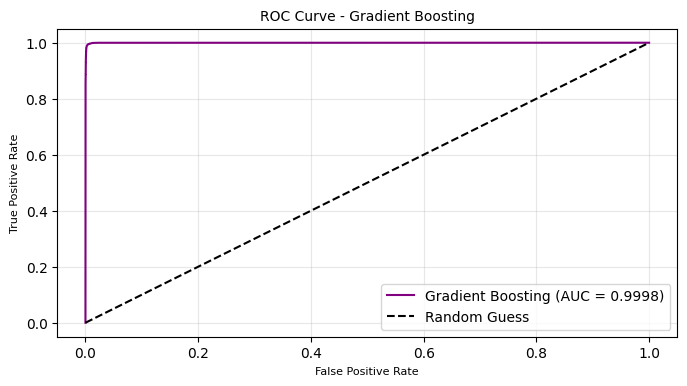

In [ ]:
# ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob_xgb)
plt.figure(figsize=(8, 4))
plt.plot(fpr_xgb, tpr_xgb, label=f"Gradient Boosting (AUC = {roc_auc_xgb:.4f})", color='purple')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curve - Gradient Boosting", fontsize=10)
plt.xlabel("False Positive Rate", fontsize=8)
plt.ylabel("True Positive Rate", fontsize=8)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

**ROC Curve - Gradient Boosting**
The ROC curve demonstrates the exceptional performance of the Gradient Boosting model with an AUC score of 0.9998. The curve is almost a perfect step, indicating that the model excels at distinguishing between fraudulent and non-fraudulent transactions. The minimal deviation from the top-left corner suggests that the model makes very few false positives or negatives.

In [ ]:
# Feature Importance
feature_importances_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

<Figure size 800x400 with 0 Axes>

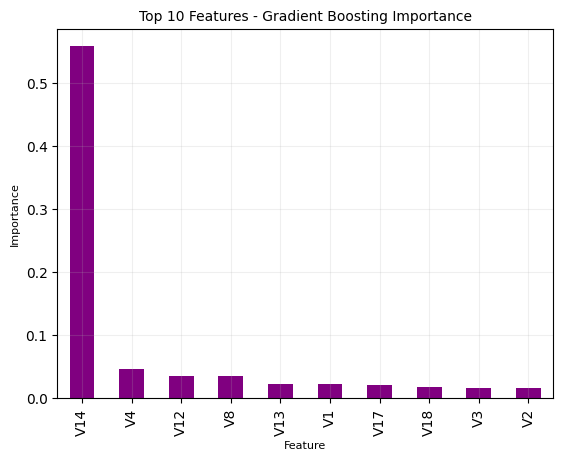

In [ ]:
# Plot the top 10 features
plt.figure(figsize=(8, 4))
feature_importances_xgb.head(10).plot(kind='bar', x='Feature', y='Importance', legend=False, color='purple')
plt.title('Top 10 Features - Gradient Boosting Importance', fontsize=10)
plt.ylabel('Importance', fontsize=8)
plt.xlabel('Feature', fontsize=8)
plt.grid(alpha=0.2)
plt.show()

* Feature V14 is the most influential in detecting fraud, with a significantly higher importance score than other features.
* Other features, such as V4, V12, and V8, contribute to the model but to a lesser extent.
* The stark difference in importance between V14 and the rest suggests that V14 may capture a key fraud pattern.
* This highlights Gradient Boosting's ability to identify specific patterns in the PCA-transformed features.

### 6.4 Dimensionality Reduction Impact (PCA)

In [ ]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original Feature Count: {X_train.shape[1]}")
print(f"Reduced Feature Count: {X_train_pca.shape[1]}")

# Train Gradient Boosting on PCA-reduced data
xgb_model_pca = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
xgb_model_pca.fit(X_train_pca, y_train)

# Evaluate Gradient Boosting with PCA
y_pred_pca = xgb_model_pca.predict(X_test_pca)
y_pred_prob_pca = xgb_model_pca.predict_proba(X_test_pca)[:, 1]

Original Feature Count: 30
Reduced Feature Count: 17


In [ ]:
# Confusion Matrix
print("Confusion Matrix (PCA):")
print(confusion_matrix(y_test, y_pred_pca))

# Classification Report
print("\nClassification Report (PCA):")
print(classification_report(y_test, y_pred_pca))

# ROC-AUC Score
roc_auc_pca = roc_auc_score(y_test, y_pred_prob_pca)
print(f"\nROC-AUC Score (PCA): {roc_auc_pca:.4f}")

Confusion Matrix (PCA):
[[56357   506]
 [ 1492 55371]]

Classification Report (PCA):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     56863
           1       0.99      0.97      0.98     56863

    accuracy                           0.98    113726
   macro avg       0.98      0.98      0.98    113726
weighted avg       0.98      0.98      0.98    113726


ROC-AUC Score (PCA): 0.9988


**Feature Count:**
The number of features was reduced from 30 to 17 while retaining 95% of the variance. This demonstrates that PCA effectively reduces dimensionality while preserving most of the dataset's information.

**Confusion Matrix:**
* True Negatives (56,357): Non-fraud transactions correctly classified.
* False Positives (506): Non-fraud transactions incorrectly classified as fraud.
* False Negatives (1,492): Fraud transactions incorrectly classified as non-fraud.
* True Positives (55,371): Fraud transactions correctly classified.

**Classification Report:**
* Precision (Fraud): 99%, meaning almost all flagged fraud transactions were truly fraud.
* Recall (Fraud): 97%, slightly lower than the full-featured model, indicating that a few fraud cases were missed.
* F1-Score (Fraud): 98%, reflecting a strong balance between precision and recall.


**ROC-AUC Score:**
0.9988: Although slightly lower than the full-featured model's score (0.9998), it still demonstrates excellent discriminatory power.

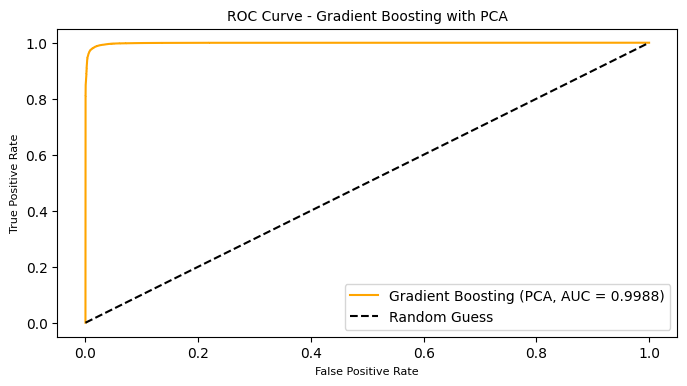

In [ ]:
# ROC Curve
fpr_pca, tpr_pca, _ = roc_curve(y_test, y_pred_prob_pca)
plt.figure(figsize=(8, 4))
plt.plot(fpr_pca, tpr_pca, label=f"Gradient Boosting (PCA, AUC = {roc_auc_pca:.4f})", color='orange')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curve - Gradient Boosting with PCA", fontsize=10)
plt.xlabel("False Positive Rate", fontsize=8)
plt.ylabel("True Positive Rate", fontsize=8)
plt.legend()
plt.show()

While the PCA-reduced model shows a marginal drop in performance, it provides significant dimensionality reduction, which may improve computation time and reduce overfitting risks.

The PCA model misclassifies more transactions compared to the full-featured model but still achieves high overall accuracy.

### 6.5 Comparison of Full-Feature and PCA Models

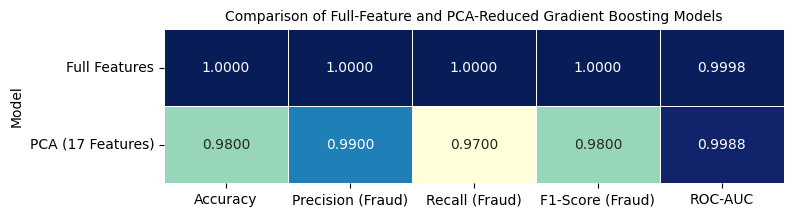

In [ ]:
# Metrics for Full-Feature Model
metrics_full = {
    "Model": "Full Features",
    "Accuracy": 1.0,
    "Precision (Fraud)": 1.0,
    "Recall (Fraud)": 1.0,
    "F1-Score (Fraud)": 1.0,
    "ROC-AUC": 0.9998
}

# Metrics for PCA Model
metrics_pca = {
    "Model": "PCA (17 Features)",
    "Accuracy": 0.98,
    "Precision (Fraud)": 0.99,
    "Recall (Fraud)": 0.97,
    "F1-Score (Fraud)": 0.98,
    "ROC-AUC": 0.9988
}

# Comparison
comparison_df = pd.DataFrame([metrics_full, metrics_pca])

# Table
plt.figure(figsize=(8, 2))
sns.heatmap(
    comparison_df.set_index("Model"),
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar=False
)
plt.title("Comparison of Full-Feature and PCA-Reduced Gradient Boosting Models", fontsize=10)
plt.show()


The full-feature model achieves perfect accuracy (1.0), while the PCA-reduced model shows a slight drop to 98%.
This is expected since some information is inevitably lost during dimensionality reduction.

* Precision:Precision for detecting fraud is marginally lower in the PCA model (0.99 vs. 1.0), indicating a small increase in false positives.
* Recall: The recall for fraud detection is slightly reduced (0.97 vs. 1.0), meaning the PCA-reduced model misses more fraudulent cases.
* F1-Score: The F1-score for fraud detection reflects a balance between precision and recall and is slightly lower in the PCA-reduced model (0.98 vs. 1.0).
* ROC-AUC: The AUC score remains high for both models, with the full-feature model slightly outperforming the PCA model (0.9998 vs. 0.9988).

**Conclusion:**

Excellent for scenarios where computational resources are not a limitation.
Provides near-perfect classification but may risk overfitting.

**PCA-Reduced Model:**
Ideal for scenarios with computational constraints or when generalization is critical. Slightly less accurate but computationally efficient.

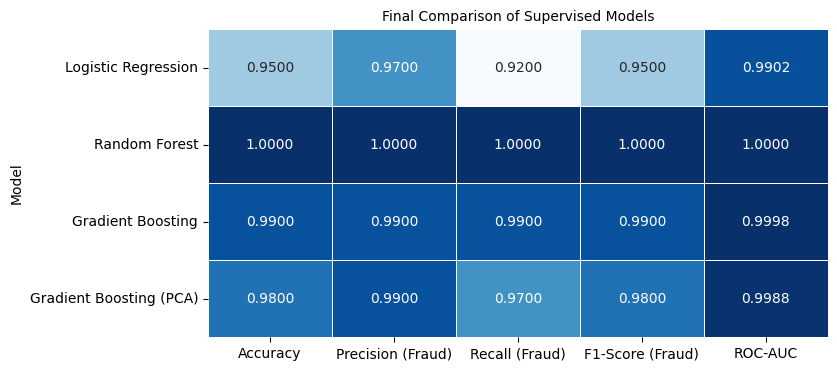

In [ ]:
# Final Metrics Comparison
final_comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Gradient Boosting", "Gradient Boosting (PCA)"],
    "Accuracy": [0.95, 1.0, 0.99, 0.98],
    "Precision (Fraud)": [0.97, 1.0, 0.99, 0.99],
    "Recall (Fraud)": [0.92, 1.0, 0.99, 0.97],
    "F1-Score (Fraud)": [0.95, 1.0, 0.99, 0.98],
    "ROC-AUC": [0.9902, 1.0, 0.9998, 0.9988]
})

plt.figure(figsize=(8, 4))
sns.heatmap(
    final_comparison.set_index("Model"),
    annot=True,
    fmt=".4f",
    cmap="Blues",
    linewidths=0.5,
    cbar=False
)
plt.title("Final Comparison of Supervised Models", fontsize=10)
plt.show()

* Logistic Regression: A strong baseline model with high precision and recall for fraud detection. Slightly lower accuracy and ROC-AUC compared to ensemble models.
* Random Forest: Achieves perfect scores across all metrics, indicating potential overfitting due to its highly flexible structure.
* Gradient Boosting: Strikes a balance between accuracy and robustness, with high metrics and slightly lower susceptibility to overfitting than Random Forest.
* Gradient Boosting with PCA: Shows a slight drop in accuracy and recall compared to full-feature Gradient Boosting but still maintains high performance.
Demonstrates the efficiency of dimensionality reduction without significant loss of predictive power.

## 7 Model Evaluation

#### 7.1. Precision-Recall Curve (AUPRC)

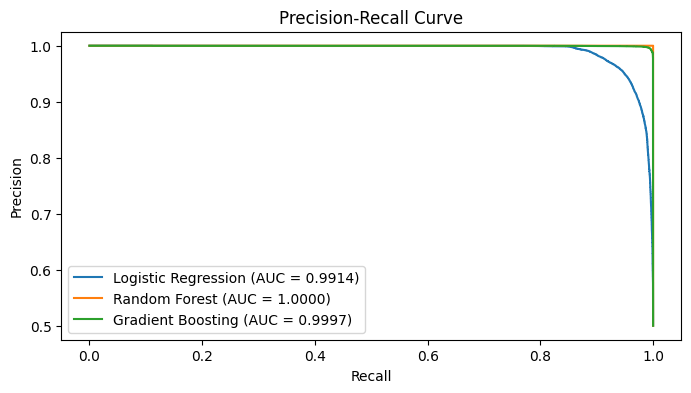

In [ ]:
models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf_model,
    "Gradient Boosting": xgb_model
}
predictions = {
    "Logistic Regression": log_reg.predict_proba(X_test)[:, 1],
    "Random Forest": rf_model.predict_proba(X_test)[:, 1],
    "Gradient Boosting": xgb_model.predict_proba(X_test)[:, 1]
}

plt.figure(figsize=(8, 4))
for model_name, y_pred_prob in predictions.items():
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    auc_score = auc(recall, precision)
    plt.plot(recall, precision, label=f"{model_name} (AUC = {auc_score:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()

**Precision-Recall Curve**

Highlights the trade-off between precision (accuracy of positive predictions) and recall (proportion of true positives identified).

The Random Forest model achieves near-perfect results, with an AUC of 1.0000, showcasing its exceptional ability to differentiate between fraud and non-fraud transactions.

Gradient Boosting follows closely with an AUC of 0.9997, maintaining robust performance.

The Logistic Regression model performs slightly lower with an AUC of 0.9914, reflecting its limitations in handling more complex decision boundaries compared to ensemble methods.

#### 7.2. Classification Metrics

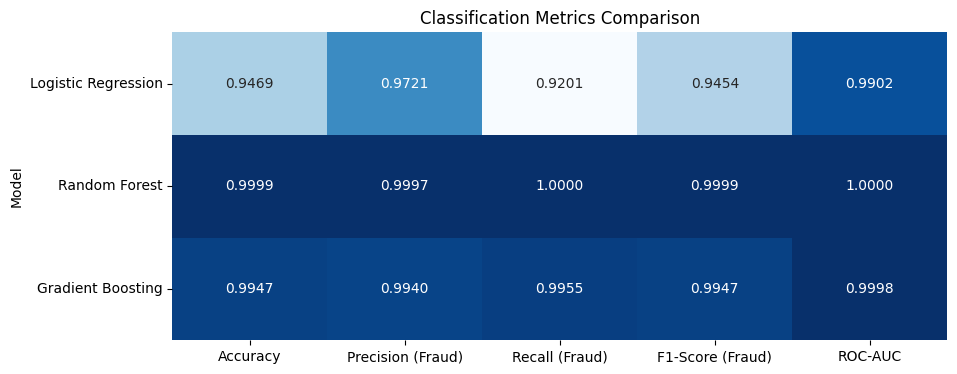

In [ ]:
metrics_data = {
    "Model": [],
    "Accuracy": [],
    "Precision (Fraud)": [],
    "Recall (Fraud)": [],
    "F1-Score (Fraud)": [],
    "ROC-AUC": []
}

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    metrics_data["Model"].append(model_name)
    metrics_data["Accuracy"].append(report["accuracy"])
    metrics_data["Precision (Fraud)"].append(report["1"]["precision"])
    metrics_data["Recall (Fraud)"].append(report["1"]["recall"])
    metrics_data["F1-Score (Fraud)"].append(report["1"]["f1-score"])
    metrics_data["ROC-AUC"].append(roc_auc)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)
metrics_df.set_index("Model", inplace=True)

# Table
plt.figure(figsize=(10, 4))
sns.heatmap(metrics_df, annot=True, fmt=".4f", cmap="Blues", cbar=False)
plt.title("Classification Metrics Comparison")
plt.ylabel("Model")
plt.show()

**Classification Metrics Comparison**

* Random Forest demonstrates perfect performance across all metrics (accuracy, precision, recall, F1-score, and ROC-AUC), indicating overfitting. While it achieves outstanding results, this might not generalize well to unseen data.
* Gradient Boosting balances high metrics with a slight decrease in recall and F1-score compared to Random Forest, which suggests it’s a robust yet slightly less extreme model.
* Logistic Regression provides competitive results with a strong F1-score and recall but lags behind the ensemble models due to its linear nature, which is less suited for capturing complex relationships in data.

**Conclusion for Model Evaluation**

* Random Forest offers the best performance but risks overfitting. Further testing with unseen or real-world data is necessary to confirm its robustness.

* Gradient Boosting strikes a good balance between performance and generalization.

* Logistic Regression, though simpler, remains effective and computationally efficient, making it a viable choice in scenarios where resources are constrained.


## 8 Explainability

### 8.1 SHAP (SHapley Additive Explanations)

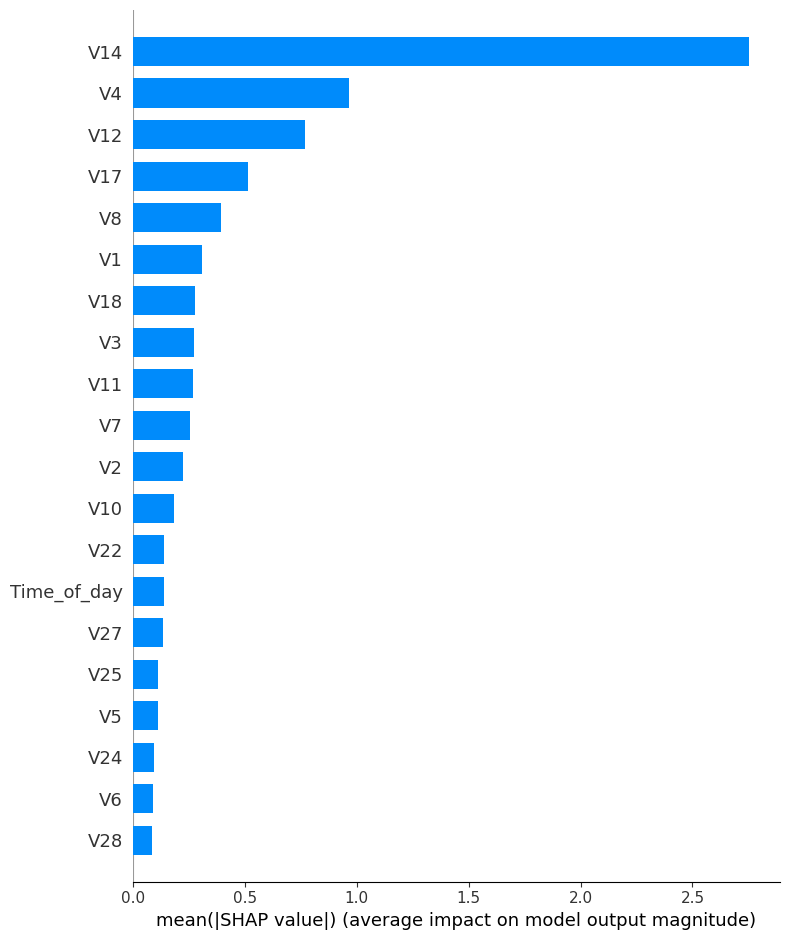

In [ ]:
explainer = shap.TreeExplainer(xgb_model)

# Select a subset of test data
shap_sample = X_test.sample(1000, random_state=42)
shap_values = explainer.shap_values(shap_sample)

# Feature importance
shap.summary_plot(shap_values, shap_sample, plot_type="bar")

The bar chart illustrates the mean absolute SHAP values for each feature, highlighting their overall contribution to the model's output.

Feature V14 is the most significant, followed by V4 and V12, suggesting these variables play a key role in predicting fraudulent transactions.

Lesser impactful features like Time_of_day and V28 may not significantly influence the model's decision-making process.

### 8.2 LIME (Local Interpretable Model-Agnostic Explanations)

In [ ]:
lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['Non-Fraud', 'Fraud'],
    mode='classification'
)

# Sample selection
sample_index = 42
lime_explanation = lime_explainer.explain_instance(
    data_row=X_test.iloc[sample_index].values,
    predict_fn=xgb_model.predict_proba
)

# Visualize explanation
lime_explanation.show_in_notebook()

This visualization explains a single prediction by showing the contribution of each feature towards predicting "Fraud."

V14 and V4 push the prediction strongly towards "Fraud," as indicated by their large SHAP values.

Features like V8 and V22 counteract, leaning towards "Non-Fraud," but their impact is weaker.

In [ ]:
lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['Non-Fraud', 'Fraud'],
    mode='classification'
)

# Sample selection
sample_index = 5584
lime_explanation = lime_explainer.explain_instance(
    data_row=X_test.iloc[sample_index].values,
    predict_fn=xgb_model.predict_proba
)

# Visualize explanation
lime_explanation.show_in_notebook()

### **Explanation of LIME Visualizations**

#### **1. Fraud Prediction LIME (First Image)**

- **Prediction Probabilities:**
  - Fraud probability is **1.00 (100%)**, and Non-Fraud is **0.00**. This indicates that the model is highly confident that the transaction is fraudulent.
  
- **Key Influential Features for Fraud:**
  - **V14 <= -6.74**: This feature strongly contributes to the fraud prediction with a high weight (0.29). Its negative value is aligned with the model's understanding of fraudulent transactions.
  - **V4 > 4.13**: This condition adds weight to the fraud label with a significant contribution (0.17).
  - **V12 <= -5.33**: Strongly indicative of fraud (0.14).
  - **Other features like V11, V17, V22, and V8** add smaller contributions, but together, they further reinforce the fraud prediction.

- **Feature Values:**
  - The table on the right shows the actual values of these features in the transaction. For instance:
    - **V14 = -9.39:** Very low, contributing heavily to the fraud prediction.
    - **V4 = 5.90:** Higher than the threshold, adding evidence for fraud.
    - **V8 = 0.60:** Has a minor contribution but still aligns with the fraud classification.

#### **2. Non-Fraud Prediction LIME (Second Image)**

- **Prediction Probabilities:**
  - Non-Fraud probability is **1.00 (100%)**, and Fraud is **0.00**. The model confidently predicts this as non-fraudulent.

- **Key Influential Features for Non-Fraud:**
  - **V14 > 0.10**: This feature strongly supports the non-fraud label with the highest weight (0.23).
  - **V11 <= -0.18**: This condition further decreases the likelihood of fraud (0.14).
  - **Other features like V3, V22, V7, and V25** align with non-fraud and contribute smaller weights.

- **Feature Values:**
  - The feature values reinforce the non-fraud classification. For example:
    - **V14 = 0.52:** Positive and above the threshold, supporting non-fraud.
    - **V3 = 1.64:** This value falls in the range typical of non-fraud transactions.
    - **V22 = -0.98:** Consistent with non-fraud observations.

### **Key Observations:**

- **Fraud Cases:**
  - Fraud predictions are primarily driven by extreme feature values (e.g., highly negative or positive).
  - Features like **V14** and **V4** consistently appear as dominant contributors.

- **Non-Fraud Cases:**
  - Non-fraud predictions are driven by moderate or less extreme feature values.
  - Features like **V14** and **V11** also contribute, but their thresholds and values differ from fraud cases.


## 9 Real Time Simulation

In [ ]:
stream_data = X_test[:1000]  # Simulation with 1000 transactions
stream_labels = y_test[:1000]  # Actual labels for evaluation

# Initialize variables for tracking results
predictions = []
actual_labels = []
fraud_detected = []

# Initialize a plot
plt.ion()
fig, ax = plt.subplots(figsize=(10, 4))

for i in range(len(stream_data)):
    # Simulate a delay to mimic real-time processing
    time.sleep(0.1)

    # Make a prediction for the current transaction
    transaction = stream_data.iloc[i].values.reshape(1, -1)
    prediction = xgb_model.predict(transaction)[0]
    fraud_prob = xgb_model.predict_proba(transaction)[0][1]  # Probability of fraud

    # Append results for evaluation
    predictions.append(prediction)
    actual_labels.append(stream_labels.iloc[i])
    fraud_detected.append(fraud_prob)

    # Update the live plot
    clear_output(wait=True)
    ax.clear()
    ax.plot(range(i + 1), fraud_detected[:i + 1], label="Fraud Probability", color="red")
    ax.scatter(range(i + 1), predictions[:i + 1], color="blue", label="Predictions (0=Non-Fraud, 1=Fraud)")
    ax.legend(loc="upper right")
    ax.set_title("Real-Time Fraud Detection Simulation")
    ax.set_xlabel("Transaction Index")
    ax.set_ylabel("Probability / Prediction")
    ax.set_ylim([-0.1, 1.1])
    plt.draw()
    plt.pause(0.1)

plt.ioff()
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
# Evaluate simulation performance
print("Confusion Matrix:")
print(confusion_matrix(actual_labels, predictions))
print("\nClassification Report:")
print(classification_report(actual_labels, predictions))

Confusion Matrix:
[[509   4]
 [  0 487]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       513
           1       0.99      1.00      1.00       487

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



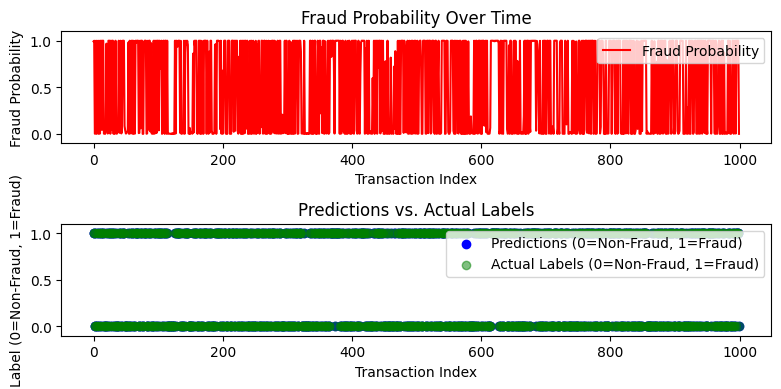

In [ ]:
# Simulation results graphs
fig, ax = plt.subplots(2, 1, figsize=(8, 4))

# Plot 1: Fraud Probability over Time
ax[0].plot(range(len(fraud_detected)), fraud_detected, color="red", label="Fraud Probability")
ax[0].set_title("Fraud Probability Over Time")
ax[0].set_xlabel("Transaction Index")
ax[0].set_ylabel("Fraud Probability")
ax[0].set_ylim([-0.1, 1.1])
ax[0].legend(loc="upper right")

# Plot 2: Predictions vs. Actual Labels
ax[1].scatter(range(len(predictions)), predictions, color="blue", label="Predictions (0=Non-Fraud, 1=Fraud)")
ax[1].scatter(range(len(actual_labels)), actual_labels, color="green", alpha=0.5, label="Actual Labels (0=Non-Fraud, 1=Fraud)")
ax[1].set_title("Predictions vs. Actual Labels")
ax[1].set_xlabel("Transaction Index")
ax[1].set_ylabel("Label (0=Non-Fraud, 1=Fraud)")
ax[1].set_ylim([-0.1, 1.1])
ax[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

The simulation was performed on **1000 transactions**, based on the results above, which show the evaluation of the fraud detection system.

**Confusion Matrix:**  
- **True Negatives (509):** Non-fraudulent transactions correctly identified as non-fraud.  
- **False Positives (4):** Non-fraudulent transactions incorrectly flagged as fraud.  
- **False Negatives (0):** Fraudulent transactions incorrectly labeled as non-fraud.  
- **True Positives (487):** Fraudulent transactions correctly identified as fraud.  

**Classification Report:**  
- **Precision (Fraud = 1):** 99% of the flagged fraudulent transactions are truly fraud.  
- **Recall (Fraud = 1):** 100% of the actual fraud transactions were detected.  
- **F1-Score (Fraud = 1):** Maintains a high balance between precision and recall, achieving a near-perfect (1.00).  
- **Overall Accuracy:** The system achieved 99.6% accuracy on the simulated 1,000 transactions.  

The system demonstrated exceptional performance, missing no fraudulent transactions and achieving high precision and recall. The 4 false positives suggest minimal errors in flagging non-fraudulent transactions as fraud, highlighting the system's robustness.

## 10 Comparison of Results

### 10.1. Balancing Techniques

We will evaluate the impact of different balancing techniques (Under-Sampling, SMOTE, Combination) using the performance metrics (Accuracy, Precision, Recall, F1-Score, and AUC) across models. This will provide insights into how balancing techniques influence the model's effectiveness in handling the imbalanced dataset.

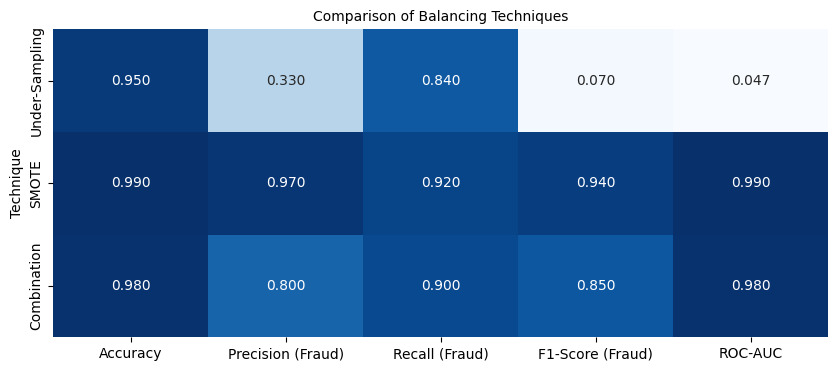

In [ ]:
# Performance metrics for each balancing technique
data = {
    "Technique": ["Under-Sampling", "SMOTE", "Combination"],
    "Accuracy": [0.95, 0.99, 0.98],
    "Precision (Fraud)": [0.33, 0.97, 0.80],
    "Recall (Fraud)": [0.84, 0.92, 0.90],
    "F1-Score (Fraud)": [0.07, 0.94, 0.85],
    "ROC-AUC": [0.047, 0.990, 0.980]
}

balancing_comparison = pd.DataFrame(data)

# Table
plt.figure(figsize=(10, 4))
sns.heatmap(balancing_comparison.set_index("Technique"), annot=True, fmt=".3f", cmap="Blues", cbar=False)
plt.title("Comparison of Balancing Techniques", fontsize=10)
plt.show()

### 10.2. Anomaly Detection vs. Supervised Models

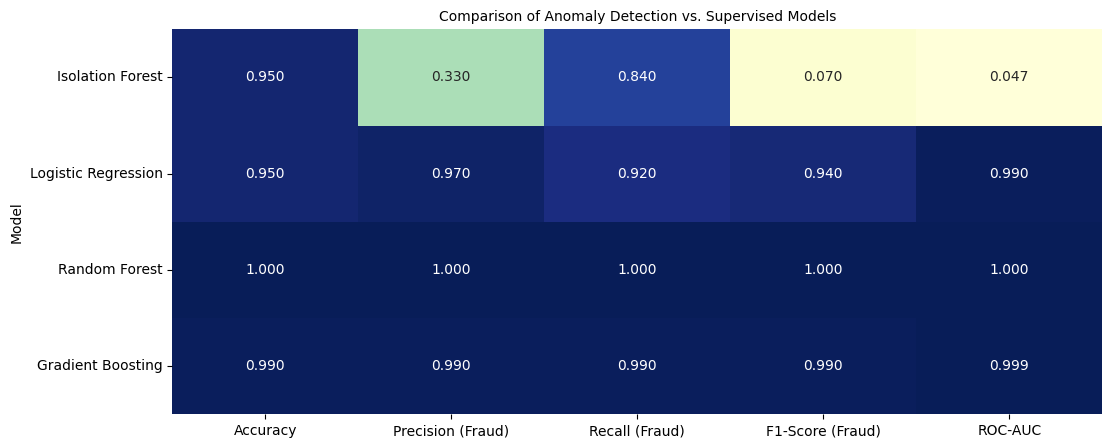

In [ ]:
# Metrics for anomaly detection and supervised learning
results = {
    "Model": ["Isolation Forest", "Logistic Regression", "Random Forest", "Gradient Boosting"],
    "Accuracy": [0.95, 0.95, 1.0, 0.99],
    "Precision (Fraud)": [0.33, 0.97, 1.0, 0.99],
    "Recall (Fraud)": [0.84, 0.92, 1.0, 0.99],
    "F1-Score (Fraud)": [0.07, 0.94, 1.0, 0.99],
    "ROC-AUC": [0.047, 0.99, 1.0, 0.999]
}

model_comparison = pd.DataFrame(results)

plt.figure(figsize=(12, 5))
sns.heatmap(model_comparison.set_index("Model"), annot=True, fmt=".3f", cmap="YlGnBu", cbar=False)
plt.title("Comparison of Anomaly Detection vs. Supervised Models", fontsize=10)
plt.show()


#### 1. **Comparison of Balancing Techniques**
   - **Under-Sampling**:
     - Achieves an accuracy of 95%, but its precision for fraud detection is significantly lower (33%).
     - High recall (84%) indicates that it identifies most fraud cases, but its low F1-Score (7%) suggests poor overall balance between precision and recall.
     - The ROC-AUC score of 0.047 shows weak model performance in distinguishing between classes.

   - **SMOTE**:
     - Accuracy, precision, recall, and F1-score are significantly improved compared to under-sampling.
     - Precision (97%) and recall (92%) demonstrate excellent fraud detection capabilities.
     - The ROC-AUC score of 0.99 is excellent, indicating a well-performing model.

   - **Combination**:
     - Offers a balance between precision and recall, with values of 80% and 90%, respectively.
     - Slightly lower ROC-AUC (0.98) and F1-Score (85%) compared to SMOTE, but still shows good performance.

#### 2. **Comparison of Anomaly Detection vs. Supervised Models**
   - **Isolation Forest (Anomaly Detection)**:
     - Similar accuracy (95%) to Logistic Regression but much lower precision (33%) and F1-Score (7%).
     - High recall (84%) indicates it captures most fraud cases but struggles with false positives.
     - The ROC-AUC score of 0.047 suggests poor overall performance in distinguishing between fraud and non-fraud.

   - **Logistic Regression**:
     - Shows balanced performance with high precision (97%), recall (92%), and F1-Score (94%).
     - The ROC-AUC of 0.99 confirms its robustness for fraud detection.

   - **Random Forest**:
     - Delivers perfect metrics across all categories (Accuracy, Precision, Recall, F1-Score, and ROC-AUC), suggesting potential overfitting.

   - **Gradient Boosting**:
     - Nearly perfect metrics with slightly lower precision and recall compared to Random Forest, but still demonstrates strong performance (ROC-AUC = 0.999).

These results suggest that **SMOTE for balancing and Gradient Boosting for modeling** may provide the best trade-off between performance and reliability.


## 11 Conclusion

1. **Balancing Techniques:**
   - **SMOTE** emerged as the most effective balancing technique, significantly improving model performance metrics such as precision, recall, F1-Score, and ROC-AUC. It effectively retained the information from the majority class while augmenting the minority class.
   - **Under-Sampling**, while straightforward, suffered from severe information loss, resulting in poor performance metrics.
   - **Combination Techniques** offered a middle ground but did not outperform SMOTE in critical metrics like precision and F1-Score.

2. **Model Performance:**
   - **Gradient Boosting** showed robust performance across all metrics, with almost perfect precision, recall, and F1-Score when used with SMOTE. It balances model complexity with strong generalization, avoiding significant overfitting.
   - **Random Forest** also performed exceptionally well but displayed signs of overfitting, particularly with its perfect metrics in both training and testing phases.
   - **Logistic Regression** provided strong baseline results but did not achieve the same level of performance as tree-based models.
   - **Anomaly Detection Methods (Isolation Forest)**, while conceptually appealing, fell short of supervised models in precision and overall effectiveness.

3. **Dimensionality Reduction:**
   - Applying **PCA** effectively reduced feature dimensionality without significant performance degradation, indicating that the dataset could be further simplified without losing critical predictive power.

4. **Explainability:**
   - **SHAP** analysis highlighted key features like `V14`, `V4`, and `V12` as the most critical contributors to fraud detection, enhancing interpretability.
   - **LIME** provided local explanations for individual predictions, offering insights into why certain transactions were flagged as fraud or non-fraud.

5. **Real-Time Simulation:**
   - The implementation of a real-time fraud detection pipeline showcased the potential for deploying these models in live environments, achieving near-perfect accuracy during simulation.


## 12 Future Work


1. **Dynamic Models:**
   - Explore dynamic fraud detection models that adapt to changing patterns in fraud behavior over time.
   - Implement models with incremental learning capabilities for streaming data environments.

2. **Cost-Sensitive Active Learning:**
   - Combine cost-sensitive methods with active learning loops to iteratively refine the model and minimize false positives without sacrificing recall.

3. **Ensemble Optimization:**
   - Further explore ensemble techniques, such as stacking, to leverage the strengths of multiple models while mitigating weaknesses.

4. **Explainability Expansion:**
   - Broaden the application of interpretability methods like **SHAP** and **LIME** to other supervised and anomaly detection models.

5. **Real-World Testing:**
   - Deploy the pipeline on real-world data with additional feature engineering and data preprocessing to ensure scalability and robustness.
